### Imports

In [35]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import plotly.express as px

# a)

### Read data

In [2]:
employment = pd.read_excel("dataset/employment_08_09.xlsx")
print(employment.shape)

(5412, 21)


In [3]:
employment.head()

,age,race,earnwke,employed,unemployed,married,union,ne_states,so_states,ce_states,...,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


### Variable overview

discrete
- binary
    - employed
    - unemployed
    - marred
    - union
    - ne_states
    - so_states
    - ce_states
    - we_states
    - private
    - government
    - self
    - educ_lths
    - educ_hs
    - educ_somecol
    - educ_adv
- integer
    - age
    - race

continuous
- earnwke

### Sanity check target variables

In theory variables `employed` and `unemployed` should be the same and containing reduntant information.

In [4]:
fig = px.histogram(employment, x="employed", color="unemployed", barmode="group")
fig.show()

One can see, that there are 435 data points which contain no information about wether or not the person was employed in 2009.

These points will be removed from the data.

In [5]:
unknown_employment_status = (employment["employed"] == employment["unemployed"])
unknown_employment_status[unknown_employment_status == True]

employment = employment[~unknown_employment_status]
employment.drop(columns="unemployed", inplace=True)
employment.head()

,age,race,earnwke,employed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [6]:
target_group = employment["employed"].value_counts()
print("Amount of employment vs. unemployment in data: {n_employed} vs. {n_unemployed}".format(n_employed=target_group[1], n_unemployed=target_group[0]))

Amount of employment vs. unemployment in data: 4738 vs. 239


### Check if missing values exist per feature

In [7]:
employment.isna().any(axis=0)

age             False
race            False
earnwke          True
employed        False
married         False
union           False
ne_states       False
so_states       False
ce_states       False
we_states       False
government      False
private         False
self            False
educ_lths       False
educ_hs         False
educ_somecol    False
educ_aa         False
educ_bac        False
educ_adv        False
female          False
dtype: bool

### Remove rows that contain missing values

In [8]:
employment.dropna(inplace=True)
employment.head()

,age,race,earnwke,employed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
2,41,1,500.00,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.00,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.00,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
5,50,3,865.38,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1
6,27,1,712.50,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


### Check for variables that do not contain any information (no information means in this case: value does not vary)

In [9]:
irrelevant_vars = set()
for col in employment:
    if col in ["age", "race", "earnwke", "employed"]:
        continue
    n_values = employment[col].value_counts()
    if len(n_values) == 1:
        print("variable '{var}' does not contain any information.".format(var=col))
        irrelevant_vars.add(col)

variable 'self' does not contain any information.


In [10]:
employment.drop(columns=[col for col in list(irrelevant_vars)], inplace=True)

### Define input and target variables

In [11]:
X = employment.drop(columns="employed")
y = employment["employed"]

### Get train/test split

In [12]:
input_train, input_test, label_train, label_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y)

## Possible model classes

The target variable is discrete (more specifically binary) and that's why we are doing classification.

Possible classification algorithms are:
- k-Nearest-Neighbour
- Logistic Regression
- Support Vector Machine
- Decision Tree
- Neural Network

## Linear Regression

In [13]:
model = linear_model.LinearRegression()
model.fit(input_train, label_train)

LinearRegression()

accuracy:  0.9478458049886621


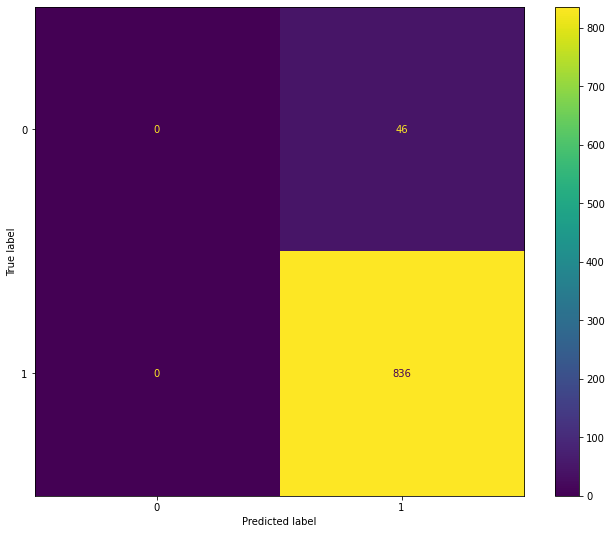

In [14]:
plt.rcParams["figure.figsize"] = (11, 9)

y_hat = model.predict(input_test)

print("accuracy: ", accuracy_score(label_test, y_hat.round()))

cm = confusion_matrix(label_test, y_hat.round())
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# b)

### Read data

In [15]:
growth = pd.read_excel("dataset/Growth.xlsx")
growth.head()

/Users/lukaskubelka/Documents/_KIT/_Studium/_M.Sc./_Semester/Semester-2/PSDA/Uebungen/E1/.venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Unknown extension is not supported and will be removed



,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,0,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,0,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,0,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333


### Get familiar with data

In [16]:
growth.sort_values(by="assasinations", ascending=False)

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
28,Guatemala,0.929231,0,1659.999756,0.509590,1.42,0.540741,2.466667
1,Argentina,0.617645,0,4462.001465,0.156623,4.99,0.933333,1.933333
30,El Salvador,-0.607556,0,1426.999878,0.527773,1.70,0.633333,1.733333
6,Spain,2.880327,0,3123.001465,0.299406,3.80,0.066667,1.433333
11,Italy,2.932981,0,4564.000488,0.330022,4.56,0.033333,1.200000
...,...,...,...,...,...,...,...,...
39,Austria,2.889185,0,5143.000977,0.575275,3.65,0.000000,0.000000
42,Costa Rica,1.613697,0,2096.000244,0.605031,3.92,0.000000,0.000000
48,Norway,3.182494,0,5610.000488,0.681555,5.56,0.000000,0.000000
43,Portugal,3.647310,0,1869.000000,0.613617,1.94,0.233333,0.000000


In [17]:
growth.sort_values(by="yearsschool", ascending=False)

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
37,Denmark,2.179370,0,6759.999023,0.560750,10.07,0.000000,0.000000
23,New Zealand,1.124132,0,7960.000977,0.455769,9.55,0.000000,0.000000
10,Australia,1.975147,0,7782.002441,0.329479,9.03,0.000000,0.066667
4,United States,1.712265,0,9895.003906,0.160815,8.66,0.000000,0.433333
21,Canada,2.385988,0,7257.997070,0.444375,8.07,0.000000,0.066667
...,...,...,...,...,...,...,...,...
17,Pakistan,2.698163,0,638.000000,0.417604,0.63,0.266667,0.266667
14,Zaire,-2.811944,0,488.999908,0.352318,0.54,0.148148,0.055556
49,Sierra Leone,-0.339834,0,877.999939,0.699433,0.53,0.474074,0.033333
44,Togo,0.462775,0,366.999939,0.626080,0.27,0.166667,0.033333


In [18]:
growth[growth["country_name"] == "Germany"]

,country_name,growth,oil,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
20,Germany,2.453688,0,6569.998535,0.442143,7.64,0.066667,0.233333


### Remove feature `oil` because it contains no information

In [19]:
growth.drop(columns="oil", inplace=True)
growth.head()

,country_name,growth,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,765.999817,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,4462.001465,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,2953.999512,0.157703,6.71,0.000000,0.200000
3,Brazil,2.930097,1783.999878,0.160405,2.89,0.100000,0.100000
4,United States,1.712265,9895.003906,0.160815,8.66,0.000000,0.433333


### Choose target variable and regressors

In [20]:
regression_data = growth.drop(columns="country_name")
y = regression_data["growth"]
X = regression_data.drop(columns="growth")
print(y)
print(X)

0     1.915168
1     0.617645
2     4.304759
3     2.930097
4     1.712265
        ...   
60    5.384184
61    4.114544
62    2.651335
63    3.024178
64    6.652838
Name: growth, Length: 65, dtype: float64
         rgdp60  tradeshare  yearsschool  rev_coups  assasinations
0    765.999817    0.140502         1.45   0.133333       0.866667
1   4462.001465    0.156623         4.99   0.933333       1.933333
2   2953.999512    0.157703         6.71   0.000000       0.200000
3   1783.999878    0.160405         2.89   0.100000       0.100000
4   9895.003906    0.160815         8.66   0.000000       0.433333
..          ...         ...          ...        ...            ...
60  2037.000366    0.979355         4.29   0.100000       0.166667
61  1420.000244    1.105364         2.34   0.033333       0.033333
62  5495.001953    1.115917         7.46   0.000000       0.000000
63  2861.999268    1.127937         2.44   0.000000       0.000000
64  1374.000000    1.992616         5.64   0.000000      

In [21]:
fig = px.scatter_matrix(regression_data, width=1024, height=720)
fig.show()

### Create training and test-split

In [22]:
input_train, input_test, target_train, target_test = train_test_split(X, y, shuffle=True)

### Baseline

In [23]:
avg_growth = target_train.mean()
print(avg_growth)

1.7345448172030349


In [32]:
y_hat = np.array([avg_growth for _ in range(len(target_test))])
print("MSE: ", mean_squared_error(target_test, y_hat))

MSE:  3.127590514762829


### Linear Regression

In [33]:
model = linear_model.LinearRegression()
model.fit(input_train, target_train)

LinearRegression()

In [36]:
y_hat = model.predict(input_test)

print("MSE: ", mean_squared_error(target_test, y_hat))
print("R2: ", r2_score(target_test, y_hat))

MSE:  2.4525068736298494
R2:  0.016660816710377446
